In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

In [2]:
import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from analysis import load_nft_trades, load_trades
from matplotlib.ticker import FuncFormatter

In [3]:
trades, nft_trades = load_trades(), load_nft_trades()

1. Plot

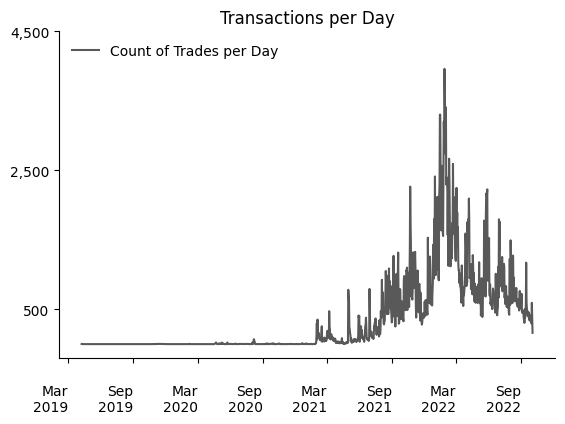

In [4]:
trades["date"] = pd.to_datetime(trades["date"])

plot_df = (
    trades[["date", "price_usd"]]
    .groupby("date")
    .count()
    .rename(columns={"price_usd": "Count of Trades per Day"})
    .loc["2019-01-01":]
    .reset_index()
)

ax = plot_df.plot.line(
    x="date",
    y="Count of Trades per Day",
    # c="Cluster",
    color="black",
    xlabel="",
    # marker=".",
    ylabel="",
    yticks=[500, 2500, 4500],
    alpha=0.65,
    title="Transactions per Day",
)
ax.legend(frameon=False, loc="upper left")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
plt.savefig("figures/trades_per_day.png")
plt.show()

2. Plot

In [5]:
eth_usd = pd.read_csv("historic_data/eth_usd.csv").rename(
    columns={"ETH_in_USD": "ETH/USD"}
)
eth_usd = eth_usd.assign(Date=pd.to_datetime(eth_usd.Date))

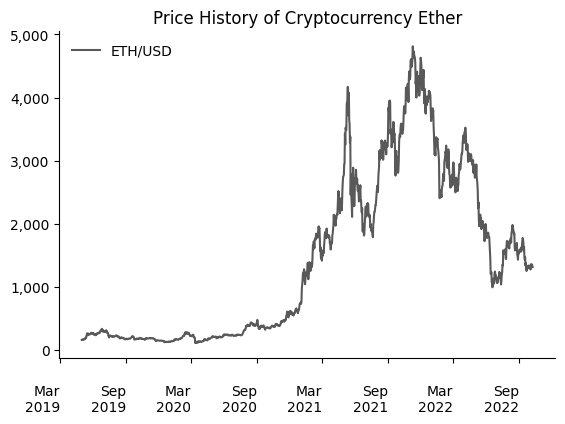

In [6]:
ax = eth_usd.plot.line(
    x="Date",
    y="ETH/USD",
    color="black",
    xlabel="",
    ylabel="",
    # yticks=[500, 2500, 4500],
    alpha=0.65,
    title="Price History of Cryptocurrency Ether",
)
ax.legend(frameon=False, loc="upper left")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
plt.savefig("figures/eth_history.png")
plt.show()

3. Plot

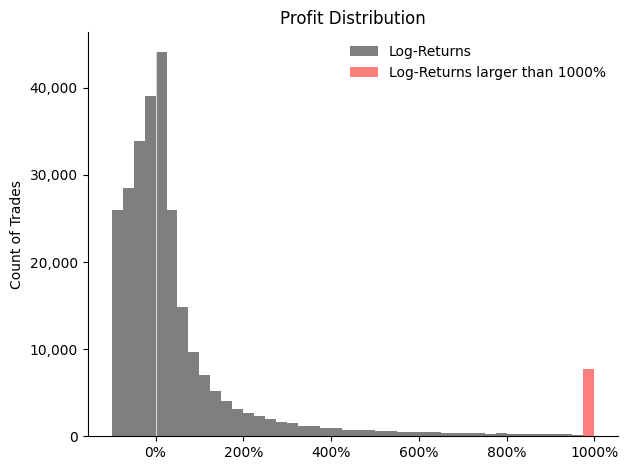

In [7]:
data = nft_trades["profit_usd"]
lower = -1
upper = 10


n, bins, patches = plt.hist(
    data, range=(lower, upper), bins=44, color="black", stacked=True, alpha=0.5
)


n_upper_outliers = (data > upper).sum()
patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
patches[-1].set_facecolor("r")
patches[-1].set_label(f"Log-Returns larger than {upper*100}%")
patches[0].set_label("Log-Returns")

plt.legend()
plt.title("Profit Distribution")
# plt.ticklabel_format(axis="x", style="scientific", useOffset=False)
ax = plt.gca()
ax.legend(frameon=False, loc="upper right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.axvline(0, color="white", linewidth=0.5)
ax.set_ylabel("Count of Trades")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
plt.tight_layout()
plt.savefig("figures/returns_hist.png")

4. Plot

In [8]:
i = -1
profit_splits = [
    -0.5,
    0,
    0.5,
    1,
    2,
    3,
    4,
    5,
    10,
    100,
    np.inf,
]
profit_dict, std_dict = {}, {}
for profit in profit_splits:
    max_profit, min_profit = profit, i
    profit_count = (
        nft_trades.groupby("from_address")
        .median()
        .query(f"{max_profit} > profit_usd >= {min_profit}")["profit_usd"]
        .count()
    )
    profit_dict[(min_profit, max_profit)] = profit_count

    i = profit
profit = pd.DataFrame(
    profit_dict.values(), columns=["Count of Addresses"], index=profit_dict.keys()
)


def format(x):
    if x != np.inf:
        x = f"{int(x*100)}%"
    return x


level_0 = profit.reset_index()["level_0"].apply(lambda x: format(x))
level_1 = profit.reset_index()["level_1"].apply(lambda x: format(x))
profit = profit.set_index([level_0, level_1])

color_list = []
for profit_split in profit_splits[:2]:
    color_list.append("red")
for profit_split in profit_splits[2:]:
    color_list.append("green")

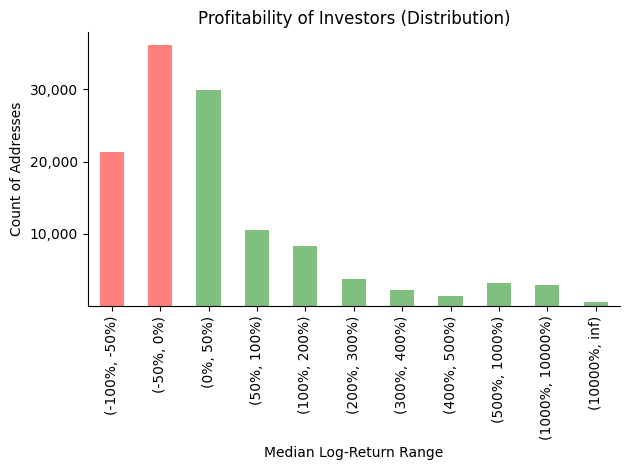

In [9]:
ax = profit["Count of Addresses"].plot.bar(
    color=color_list,
    ylabel="Count of Addresses",
    xlabel="Median Log-Return Range",
    title="Profitability of Investors (Distribution)",
    yticks=[10000, 20000, 30000],
    alpha=0.5,
)
fmt = "{x:,.0f}"
tick = mtick.StrMethodFormatter(fmt)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_major_formatter(tick)
plt.tight_layout()
plt.savefig("figures/profit_per_investor.png")

5. Plot

<Figure size 100x800 with 0 Axes>

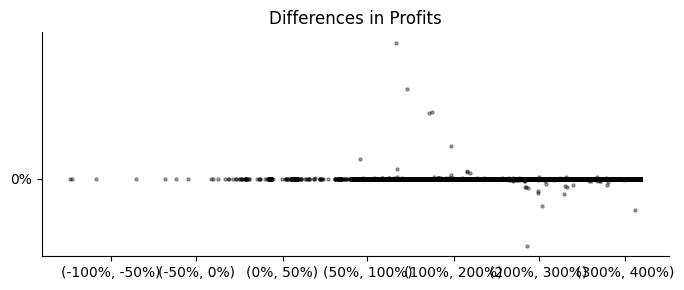

In [10]:
nft_trades["usd_eth_dif"] = nft_trades["profit_usd"] - nft_trades["profit_eth"]
fig = plt.figure(figsize=(1, 8))
fig.ax = nft_trades.plot.scatter(
    x="sell_date",
    y="usd_eth_dif",
    marker=".",
    color="black",
    logy=False,
    ylabel="",
    xlabel="",
    title=f"Differences in Profits",
    alpha=0.35,
    yticks=[0],
    figsize=(7, 3),
)
fig.ax.spines["top"].set_visible(False)
fig.ax.spines["right"].set_visible(False)
fig.ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
fig.ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
fig.ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, is_latex=True))
plt.tight_layout()
plt.savefig("figures/eth_usd_dif.png")
plt.show()

6. Plot

In [11]:
sell_date = (
    nft_trades.groupby("sell_date").agg(["count", "median", "mean"])["profit_usd"]
    # .query("median < 10")
)

In [12]:
plot_df = (
    sell_date.rolling(7)
    .median()[["median"]]
    .dropna()
    .rename(columns={"median": "Weekly Rolling Median"})
)

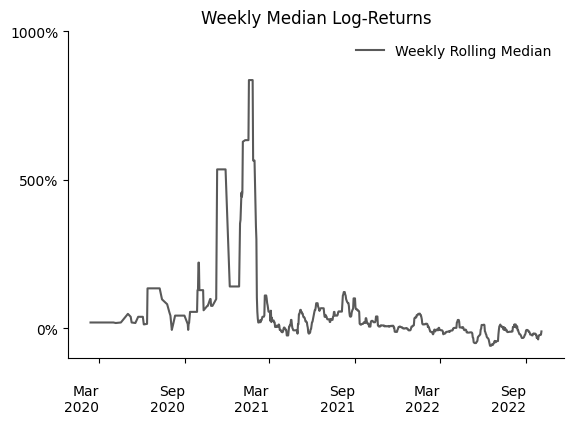

In [13]:
plot_df[0] = 0
ax = plot_df.plot(
    y="Weekly Rolling Median",
    color="black",
    xlabel="",
    title="Weekly Median Log-Returns",
    ylim=(-1, 10),
    alpha=0.65,
    yticks=[0, 5, 10],
)
ax.legend(frameon=False, loc="upper right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))

ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.savefig("figures/rolling_weekly.png")

7. Plot

In [14]:
holding_period = (
    nft_trades.groupby("holding_period")
    .agg(["count", "median", "mean"])["profit_usd"]
    .query("median < 10")
    .reset_index()
)

In [15]:
holding_period[holding_period["count"] == holding_period["count"].max()]["mean"] * 100

0    1166.971593
Name: mean, dtype: float64

<AxesSubplot: >

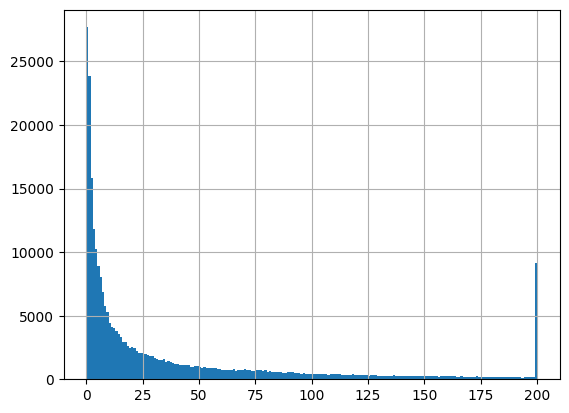

In [16]:
np.clip(nft_trades.holding_period, a_min=0, a_max=200).hist(bins=200)

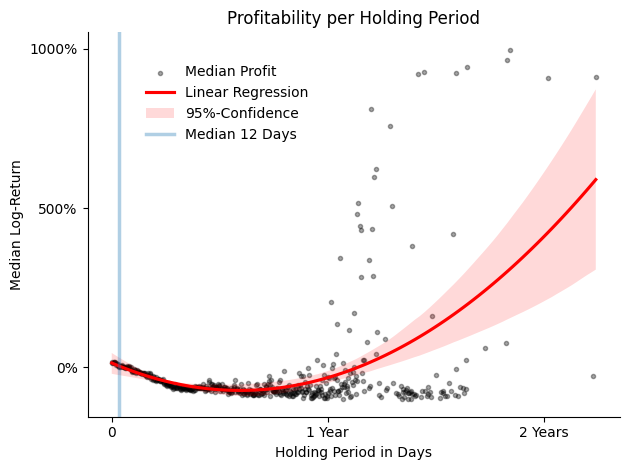

In [17]:
ax = sns.regplot(
    x=holding_period["holding_period"],
    y=holding_period["median"],
    # robust=True,
    marker=".",
    scatter_kws={"color": "black", "alpha": 0.35},
    line_kws={"color": "red"},
    ci=95,
    order=2,
)

plt.axvline(
    nft_trades["holding_period"].median(),
    label=f"Median {int(nft_trades.holding_period.median())} Days",
    alpha=0.35,
    linewidth=2.5,
)
ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 365, 730], labels=[0, "1 Year", "2 Years"])
ax.set_xlabel("Holding Period in Days")
ax.set_ylabel("Median Log-Return")
ax.set_title("Profitability per Holding Period")
plt.legend(
    ["Median Profit", "Linear Regression", "95%-Confidence", "Median 12 Days"],
    frameon=False,
    loc=(0.1, 0.7),
)
# ax.legend(frameon=False, loc="upper center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.savefig("figures/profit_per_holding_period.png")

8. Plot

In [18]:
grouped_trades = (
    trades.groupby("date")
    .agg(["sum", "count"])["price_usd"]
    .rolling(30)
    .sum()
    .loc[datetime.date(2021, 1, 1) :]
)
# grouped_trades["x"] = grouped_trades["count"]
grouped_trades["Total Liquidity per Month"] = grouped_trades["sum"] / 1000000

<Figure size 640x480 with 0 Axes>

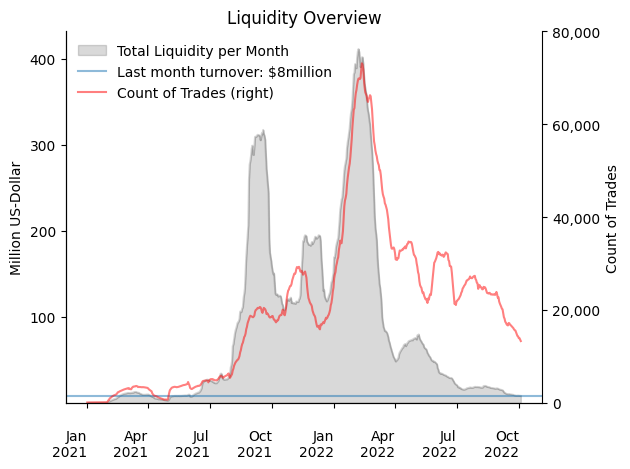

In [19]:
grouped_trades["Count of Trades"] = grouped_trades["count"].copy()

fig = plt.figure()

fig.ax = grouped_trades.plot.area(
    y="Total Liquidity per Month",
    color="black",
    ylabel="Million US-Dollar",
    xlabel="",
    title="Liquidity Overview",
    alpha=0.15,
    stacked=False,
    legend=False,
    yticks=[100, 200, 300, 400],
)

fig.ax3 = plt.axhline(
    grouped_trades["Total Liquidity per Month"].iloc[-1],
    label=f"Last month turnover: $"
    + str(int(grouped_trades["Total Liquidity per Month"].iloc[-1]))
    + "million",
    alpha=0.5,
)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
fig.ax2 = grouped_trades.plot.line(
    y="Count of Trades",
    color="red",
    ylabel="Count of Trades",
    xlabel="",
    title="Liquidity Overview",
    alpha=0.5,
    secondary_y=True,
    ax=fig.ax,
    ylim=(0, 80000),
    legend=False,
    yticks=[0, 20000, 40000, 60000, 80000],
)

fmt = "{x:,.0f}"
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)
fig.ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
fig.ax.set_xticklabels(fig.ax.xaxis.get_majorticklabels(), rotation=0)
# fig.ax2.xaxis.set_major_locator(mdates.MonthLocator([6]))

handles, labels = [], []
for ax in fig.axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.ax.legend(
    handles=handles,
    labels=labels,
    loc="upper left",
    frameon=False,
)
fig.ax2.legend(
    handles=handles,
    labels=labels,
    loc=(0.015, 0.8),
    frameon=False,
)


plt.gca().spines["top"].set_visible(False)


plt.tight_layout()
plt.savefig("figures/liquidity.png")

In [20]:
gas_fees = pd.read_csv("historic_data/AverageDailyTransactionFee.csv")

In [21]:
gas_fees["Date"] = pd.to_datetime(gas_fees["Date(UTC)"]).dt.date

In [22]:
import datetime

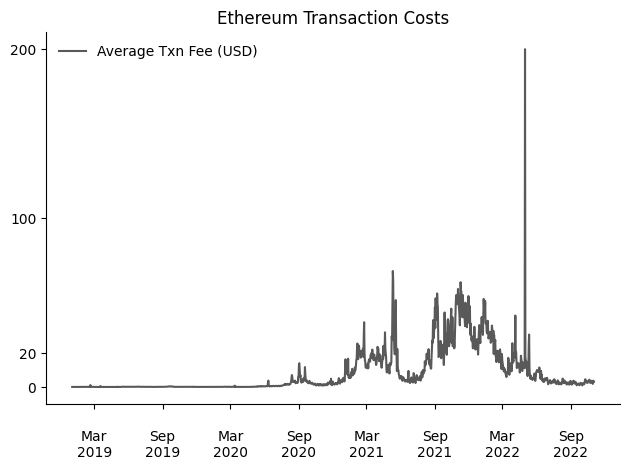

In [23]:
ax = gas_fees.set_index("Date")[["Average Txn Fee (USD)"]].loc[datetime.datetime(2019,1,1).date():].plot(
    color="black", alpha=0.65, title = "Ethereum Transaction Costs", xlabel="", yticks=[0,20,100, 200]
)
ax.legend(frameon=False, loc="upper left")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.savefig("figures/gasfees.png")

9. Plot

In [24]:
collection_count = (
    nft_trades.groupby("collection")
    .agg(["count", "median", "mean"])["profit_usd"]
    .query("median < 10")
)
collection_count = collection_count.groupby("count").mean().reset_index()

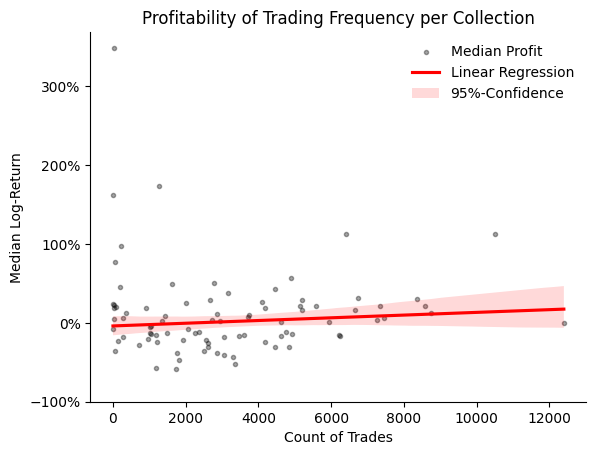

In [25]:
ax = sns.regplot(
    x=collection_count["count"],
    y=collection_count["median"],
    robust=True,
    marker=".",
    scatter_kws={"color": "black", "alpha": 0.35},
    line_kws={"color": "red"},
)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Count of Trades")
ax.set_ylabel("Median Log-Return")
ax.set_title("Profitability of Trading Frequency per Collection")
plt.legend(["Median Profit", "Linear Regression", "95%-Confidence"], frameon=False)
plt.savefig("figures/profit_per_collection_trades.png")

10. Plot

In [26]:
address_count = (
    nft_trades.groupby("from_address")
    .agg(["count", "median", "mean", "sum"])["profit_usd"]
    .query("mean < 10")
)

In [27]:
address_count = address_count.groupby("count").mean().reset_index()

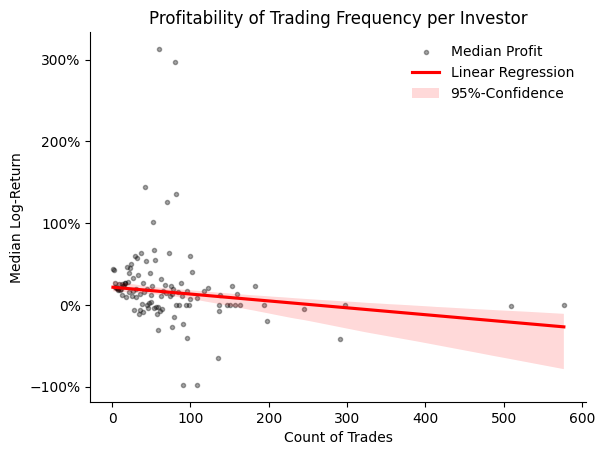

In [28]:
ax = sns.regplot(
    x=address_count["count"],
    y=address_count["median"],
    robust=True,
    marker=".",
    scatter_kws={"color": "black", "alpha": 0.35},
    line_kws={"color": "red"},
    label="test",
    # order=2
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Count of Trades")
ax.set_ylabel("Median Log-Return")
ax.set_title("Profitability of Trading Frequency per Investor")
plt.legend(["Median Profit", "Linear Regression", "95%-Confidence"], frameon=False)
plt.savefig("figures/profit_per_investor_trades.png")

11. Plot

In [29]:
i = 0
price_splits = [
    100,
    1000,
    5000,
    10000,
    15000,
    20000,
    25000,
    50000,
    100000,
    200000,
    500000,
    np.inf,
]
profit_dict, std_dict = {}, {}
for price in price_splits:
    max_price, min_price = price, i
    purchase_price_median = nft_trades.query(
        f"{max_price} > purchase_price_usd > {min_price}"
    )["profit_usd"].median()
    purchase_price_std = nft_trades.query(
        f"{max_price} > purchase_price_usd > {min_price}"
    )["profit_usd"].std()
    profit_dict[(min_price, max_price)] = purchase_price_median
    std_dict[(min_price, max_price)] = purchase_price_std

    i = price
profit = pd.DataFrame(
    profit_dict.values(), columns=["Median Profit"], index=profit_dict.keys()
)
std = pd.DataFrame(
    std_dict.values(), columns=["Standard Deviation"], index=std_dict.keys()
)
profit_cluster = pd.concat([profit, std], axis=1).reset_index()
profit_cluster["positive_return"] = profit_cluster["Median Profit"].apply(
    lambda x: (True) if x >= 0 else (False)
)
color_dict = {True: "green", False: "red"}


def format(x):
    if x != np.inf:
        x = "{:,}".format(x)
    return x


profit_cluster["buy_0"] = profit_cluster.reset_index()["level_0"].apply(
    lambda x: format(x)
)
profit_cluster["buy_1"] = profit_cluster.reset_index()["level_1"].apply(
    lambda x: format(x)
)
profit_cluster = profit_cluster.set_index(["buy_0", "buy_1"])

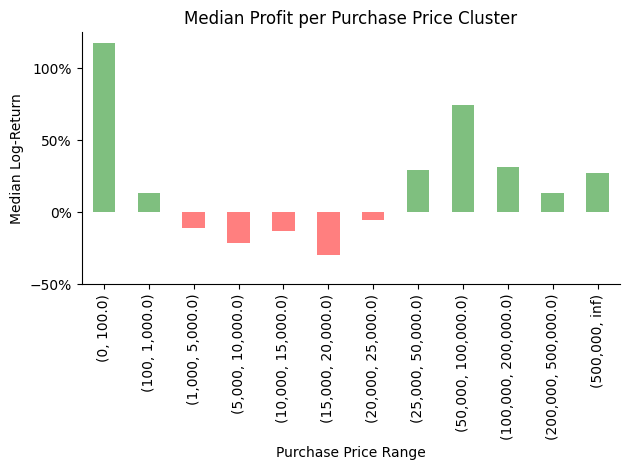

In [30]:
ax = profit_cluster["Median Profit"].plot.bar(
    color=[color_dict[r] for r in profit_cluster["positive_return"]],
    ylabel="Median Log-Return",
    title="Median Profit per Purchase Price Cluster",
    xlabel="Purchase Price Range",
    alpha=0.5,
    yticks=[-0.5, 0, 0.5, 1],
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/profit_per_price.png")

In [37]:
rf = 0.045
profit_cluster["risk_return"] = (profit_cluster["Median Profit"] - rf) / profit_cluster[
    "Standard Deviation"
]

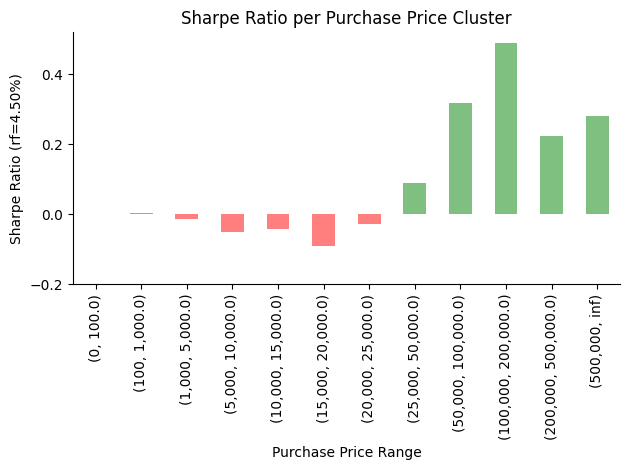

In [38]:
risk_return_cluster = profit_cluster  # .sort_values("risk_return", ascending=False)
ax = risk_return_cluster["risk_return"].plot.bar(
    color=[color_dict[r] for r in risk_return_cluster["positive_return"]],
    title="Sharpe Ratio per Purchase Price Cluster",
    ylabel="Sharpe Ratio (rf=4.50%)",
    xlabel="Purchase Price Range",
    alpha=0.5,
    yticks=[-0.2, 0, 0.2, 0.4],
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.savefig("figures/sharpe_ratio_per_purchase_price.png")

In [33]:
spx = pd.read_csv("historic_data/spx.csv")
spx = spx.assign(Date=pd.to_datetime(spx.Date)).set_index("Date")
eth_usd = pd.read_csv("historic_data/eth_usd.csv")
eth_usd = eth_usd.assign(Date=pd.to_datetime(eth_usd.Date)).set_index("Date")
nft_index = nft_trades.groupby("sell_date").median().pct_change()["sell_price_usd"]
market = spx.merge(eth_usd, how="inner", left_index=True, right_index=True).pct_change()
market.iloc[0] = [1, 1]
market = market.merge(nft_index, how="inner", left_index=True, right_index=True)

market = market.rolling(7).median().dropna()
market.iloc[0] = [1, 1, 1]
market = market.cumsum()  # .sub(1)

market = market.rename(
    columns={
        "spx": "S&P 500",
        "ETH_in_USD": "ETH/USD",
        "sell_price_usd": "NFT Art Index",
    }
)

<Figure size 640x480 with 0 Axes>

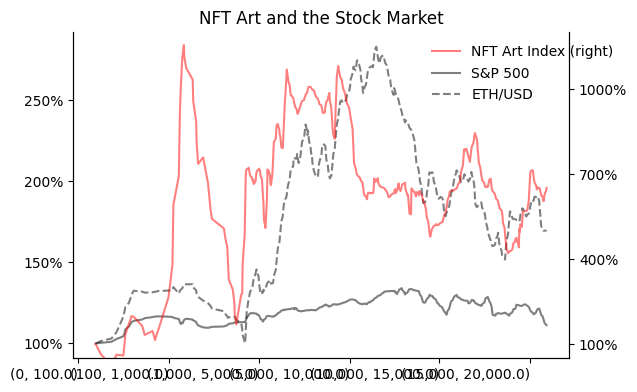

In [34]:
fig = plt.figure()
fig.ax = market[["S&P 500"]].plot(
    color="black", alpha=0.5, legend=False, yticks=[1, 1.5, 2, 2.5, 3]
)
market[["ETH/USD"]].plot(
    ax=fig.ax, color="black", alpha=0.5, linestyle="--", legend=False
)
fig.ax2 = market[["NFT Art Index"]].plot(
    ax=fig.ax,
    secondary_y=True,
    ylim=(0.5, 12),
    color="red",
    alpha=0.5,
    legend=False,
    yticks=[1, 4, 7, 10, 13],
)
fig.ax2.spines["top"].set_visible(False)
fig.ax.spines["top"].set_visible(False)
handles, labels = [], []
for ax in fig.axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.ax.legend(
    handles=handles,
    labels=labels,
    loc=(0.713, 0.77),
    frameon=False,
)
fig.ax2.legend(
    handles=handles,
    labels=["NFT Art Index"],
    loc=(0.713, 0.90),
    frameon=False,
)
fig.ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
fig.ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
fig.ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
fig.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().set_title("NFT Art and the Stock Market")
plt.savefig("figures/nft_index.png")

In [35]:
import numpy as np
import pandas as pd

In [36]:
import pandas as pd

# Create example df
significance_list = [False, True, True, True, False, False, True, True]

mbt = pd.DataFrame(
    data=[
        ["positive" for x in range(10)],
        ["negative" for x in range(10)],
        significance_list,
    ]
).T
mbt.columns = ["long_term_slope", "short_term_slope", "significance_flag"]

############################################################


# Get significance flag from previous day:
mbt["prev_significance_flag"] = mbt["significance_flag"].shift(1)


def set_trade_flag(row):
    if (
        (row["long_term_slope"] == "positive")
        & (row["short_term_slope"] == "negative")
        & (row["significance_flag"] == True)
        & (row["prev_significance_flag"] == False)
    ):
        return "invested"
    elif (
        (row["long_term_slope"] == "positive")
        & (row["short_term_slope"] == "negative")
        & (row["significance_flag"] == False)
        & (row["prev_significance_flag"] == True)
    ):
        return "not invested"
    else:
        return None


mbt["trade_flag"] = mbt.apply(lambda row: set_trade_flag(row), axis=1).fillna(
    method="ffill"
)

mbt

,long_term_slope,short_term_slope,significance_flag,prev_significance_flag,trade_flag
0,positive,negative,False,None,None
1,positive,negative,True,False,invested
2,positive,negative,True,True,invested
3,positive,negative,True,True,invested
4,positive,negative,False,True,not invested
5,positive,negative,False,False,not invested
6,positive,negative,True,False,invested
7,positive,negative,True,True,invested
8,positive,negative,None,True,invested
9,positive,negative,None,None,invested
